In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import autograd.numpy as np
from autograd import grad 

# element-wise gradient is a standard-alone function in v1.2
from autograd import elementwise_grad as egrad

import autograd.numpy.random as npr
from autograd.misc.flatten import flatten_func, flatten

from scipy.integrate import odeint # for comparision
from scipy.optimize import minimize

## Scipy ODE solver

Note: scipy.integrate.odeint expects f(y, t) but scipy.integrate.ode expects f(t, y) 

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode

In [2]:
def f(t, y):
    '''
        dy/dt = f(t, y)
        This is f() function on the right
    '''    
    return -y + np.sin(t)

f_yt = lambda y,t: f(t, y) # this is for odeint

In [3]:
t = np.linspace(0, 6, 20).reshape(-1,1)
y = odeint(f_yt, y0=1, t=t.ravel())

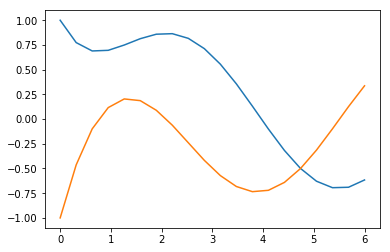

In [4]:
plt.plot(t,y)
plt.plot(t,f(t,y))

## Build neural net

- https://becominghuman.ai/neural-networks-for-solving-differential-equations-fa230ac5e04c
- https://github.com/Rachnog/Neural-Networks-for-Differential-Equations/blob/master/ODE%20example.ipynb

In [5]:
dt = t[1] - t[0]
print(t.shape, dt) 

(20, 1) [ 0.31578947]


In [6]:
def init_weights(n_in=1, n_hidden=10, n_out=1):
    W1 = npr.randn(n_in, n_hidden)
    b1 = np.zeros(n_hidden)
    W2 = npr.randn(n_hidden, n_out)
    b2 = np.zeros(n_out)
    params = [W1, b1, W2, b2]
    return params

params = init_weights()
print([ p.shape for p in params ])

[(1, 10), (10,), (10, 1), (1,)]


In [7]:
def predict(params, t, act=np.tanh, y0=1):
    W1, b1, W2, b2 = params
    
    a = act(np.dot(t, W1) + b1)
    y = np.dot(a, W2) + b2
    
    phi = y0 + t*y
    
    return phi

In [8]:
predict(params, t).shape # vectorized over t

(20, 1)

In [9]:
predict_dt = egrad(predict, argnum=1) # element-wise grad w.r.t t, 

In [10]:
predict_dt(params, t).shape # this is correct

(20, 1)

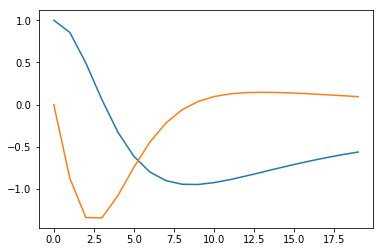

In [11]:
plt.plot(predict(params, t))
plt.plot(predict_dt(params, t))

In [12]:
def loss_func(params, t):
    y_pred =  predict(params, t)
    dydt_pred = predict_dt(params, t)
    f_pred = f(t, y_pred)
    return np.sum( (dydt_pred-f_pred)**2 )

In [13]:
loss_func(params, t)

32.554391797166588

In [14]:
# loss_grad = grad(loss_func)

In [15]:
flattened_params, unflat_func = flatten(params)

In [16]:
def loss_wrap(flattened_params, t):
    params = unflat_func(flattened_params) # recover
    return loss_func(params, t)

grad_wrap = grad(loss_wrap)

In [17]:
loss_wrap(flattened_params, t)

32.554391797166588

In [18]:
def loss_part(flattened_params):
    '''make partial function. 
    Use this simple method because
    autograd or scipy does not like functool.partial'''
    # warning: global t is used
    return loss_wrap(flattened_params, t)

In [19]:
loss_part_grad = grad(loss_part)

In [20]:
# repeat with different initial weights for timing
params = init_weights() 
flattened_params, _ = flatten(params)

In [21]:
%%time
optim_params = minimize(loss_part, x0=flattened_params, 
                        jac=loss_part_grad, method="BFGS")
# jac = loss_part_grad is now faster in v1.2

CPU times: user 2.62 s, sys: 12.9 ms, total: 2.63 s
Wall time: 2.65 s


In [22]:
o = optim_params
print(o.fun, o.njev, o.nfev, '\n', o.message)

1.2299095018033651e-07 982 982 
 Optimization terminated successfully.


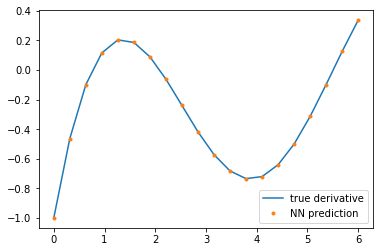

In [23]:
plt.plot(t, f(t,y), label='true derivative')
plt.plot(t, predict_dt(unflat_func(o.x), t), '.', label='NN prediction')
plt.legend()

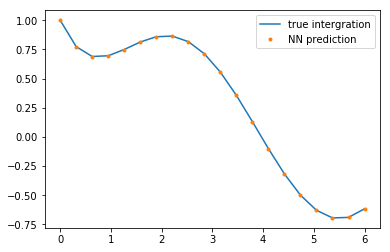

In [24]:
plt.plot(t, y, label='true intergration')
plt.plot(t, predict(unflat_func(o.x), t), '.', label='NN prediction')
plt.legend()